In [1]:
import tensorflow as tf
import os
import numpy as np
import itertools

import matplotlib
matplotlib.use("agg")
import pylab as plt

import pandas as pd
from tqdm import tqdm
import collections
import math
import sys

%matplotlib inline

ds = tf.contrib.distributions
DATA_LLIM = -4.0
DATA_RLIM = 4.0
NUM_MODES_PER_DIM = 5

C:\Users\hnpathak\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
def create_distribution(BATCH_SIZE, num_components=25, num_features=2,**kwargs):
    cat = ds.Categorical(tf.zeros(num_components, dtype=tf.float32))
    mus = np.array([np.array([i, j]) for i, j in 
                    itertools.product(np.linspace(DATA_LLIM, DATA_RLIM, NUM_MODES_PER_DIM),
                                      np.linspace(DATA_LLIM, DATA_RLIM, NUM_MODES_PER_DIM))],dtype=np.float32)

    s = 0.1
    sigmas = [np.array([s,s]).astype(np.float32) for i in range(num_components)]
    components = list((ds.MultivariateNormalDiag(mu, sigma) 
                       for (mu, sigma) in zip(mus, sigmas)))
    data = ds.Mixture(cat, components)
    return data.sample(BATCH_SIZE)

def data_mixture(shape , **kawrgs):
    return create_distribution(shape[0],25,shape[1],**kawrgs)

In [3]:
def linear(input_, output_size, scope = None, stddev=0.02, bias_start=0.0):
    
    shape = input_.get_shape().as_list()
    
    with tf.variable_scope(scope or "Linear"):
        
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32, tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
        
        return tf.matmul(input_, matrix) + bias

In [4]:
def discriminator(x, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
        h0 = tf.nn.relu(linear(x, DF_DIM, scope="d_h0"))
        h1 = tf.nn.relu(tf.sigmoid(linear(h0, DF_DIM, scope="d_h1")))
            
        return tf.sigmoid(linear(h1, 1, scope="d_h2"))

In [5]:
def generator(z, reuse=False):
    with tf.variable_scope("generator") as scope:
        if reuse:
            scope.reuse_variables()
        h0 = tf.nn.relu(linear(z, GF_DIM, scope="g_h0"))
        h1 = tf.nn.relu(linear(h0, GF_DIM, scope="g_h1"))

        return linear(h1, DATA_DIMS, scope="g_h2")

In [6]:
def sample_Z():
    batch_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)
    return batch_z

In [13]:
def build_model():
    
    inputs = tf.placeholder(tf.float32, [BATCH_SIZE, DATA_DIMS], name='real_data')
    z = tf.placeholder(tf.float32, [BATCH_SIZE, Z_DIM], name='z')
    #learning_rate = tf.Variable(tf.zeros([]), name='alr')
    
    G = generator(z)
    sampler = generator(z, reuse=True)
    
    D_logits = discriminator(inputs)
    D_logits_ = discriminator(G, reuse=True)
    
    #Jenson-Shenon(JS) divergence
    g_loss = -tf.reduce_mean(tf.log(D_logits_))
    #g_loss = tf.reduce_mean(tf.log(1- D_logits_))
    d_loss = -tf.reduce_mean(tf.log(D_logits) + tf.log(1. - D_logits_))
        
    t_vars = tf.trainable_variables()

    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = [var for var in t_vars if 'g_' in var.name]

    d_optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE)
    g_optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE)

    d_optim = d_optimizer.minimize(d_loss, var_list=d_vars)
    g_optim = g_optimizer.minimize(g_loss, var_list=g_vars)
        
    return z, inputs, sampler, g_loss, d_loss, g_optim, d_optim

In [14]:
### Data and network initializations ######
BATCH_SIZE = 200
Z_DIM = 10
DATA_DIMS = 2
DF_DIM = 128
GF_DIM = 128
LEARNING_RATE = 5e-3
LOGFILE_NAME = "logfile"
D_ITERS = 2
BASEDIR ="okl/"
G_ITERS = 600


C:\Users\hnpathak\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


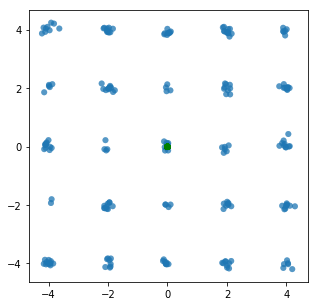

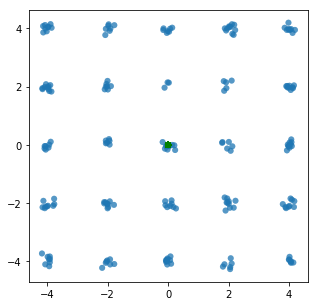

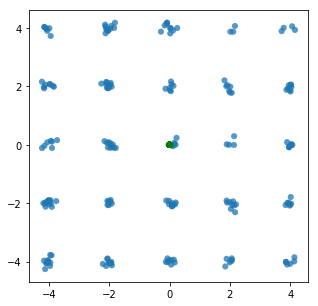

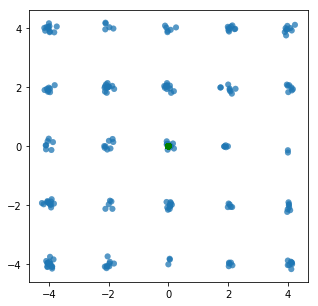

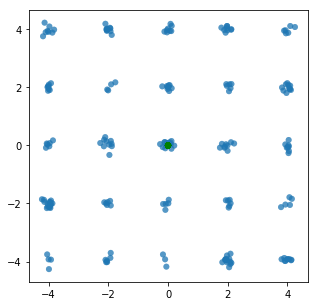

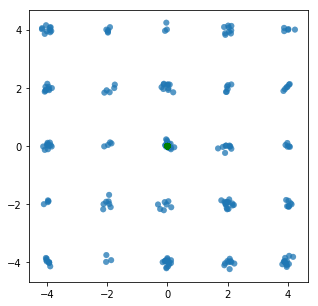

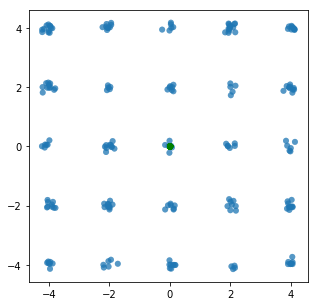

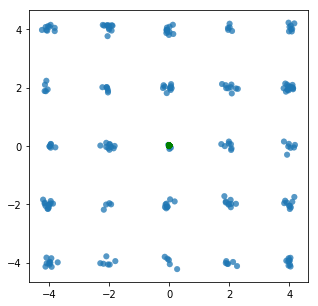

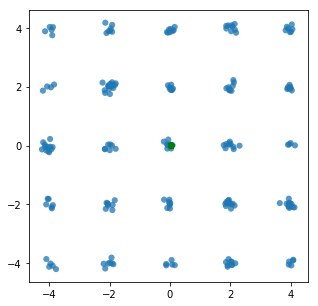

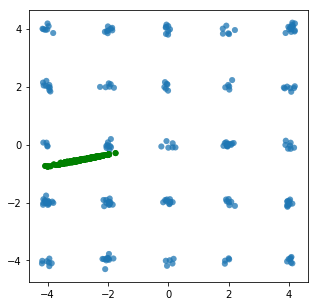

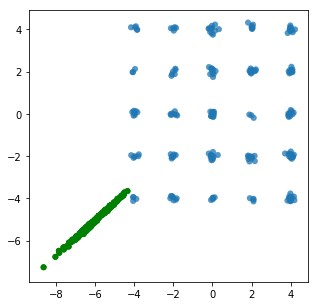

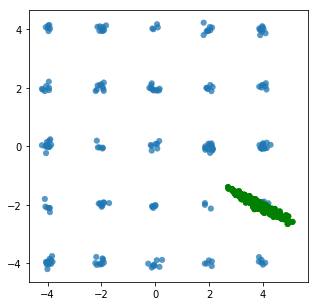

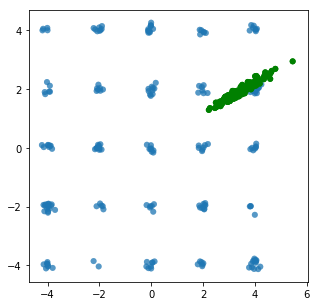

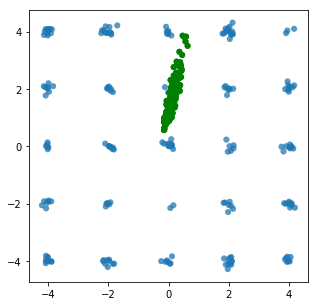

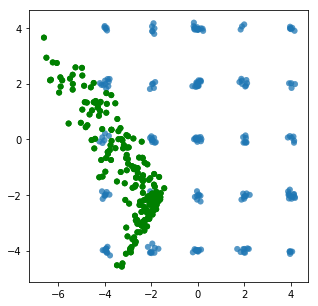

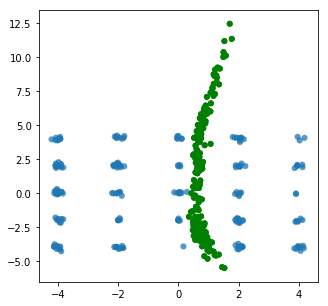

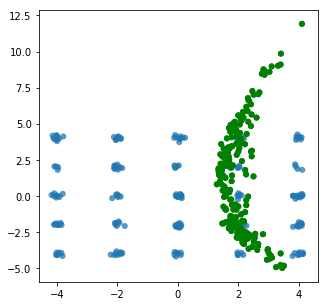

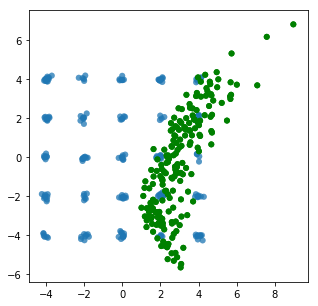

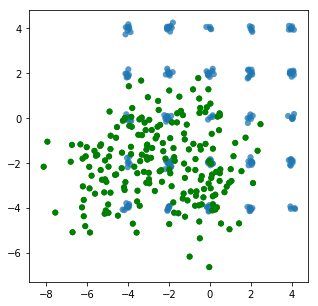

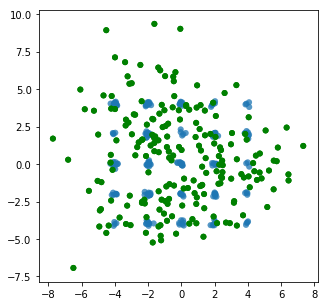

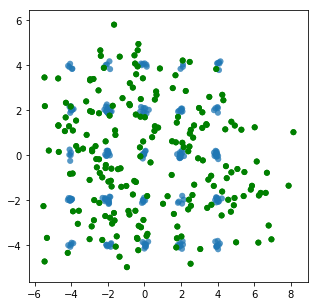

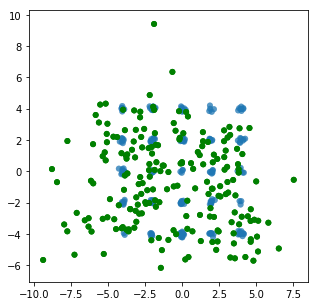

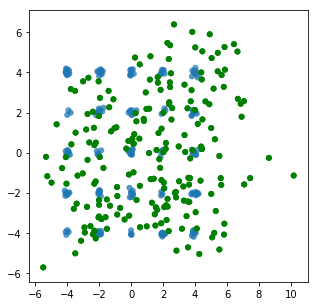

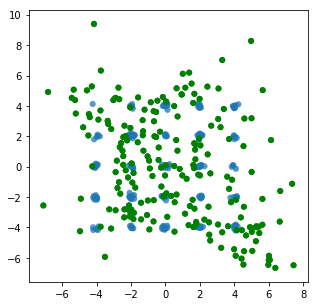

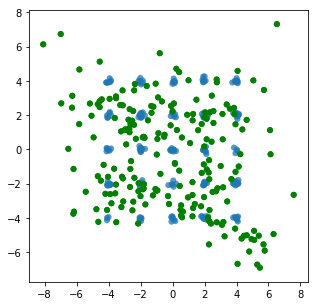

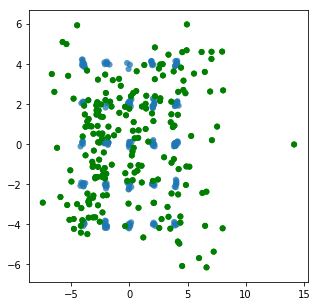

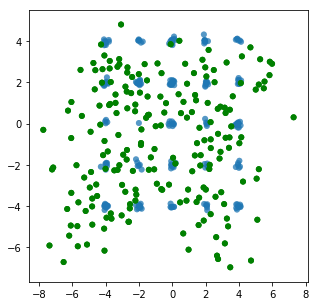

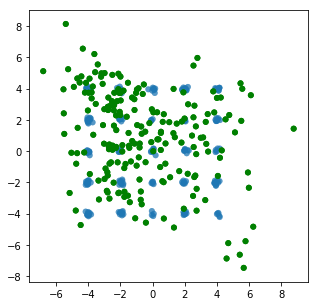

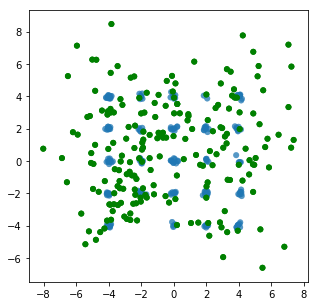

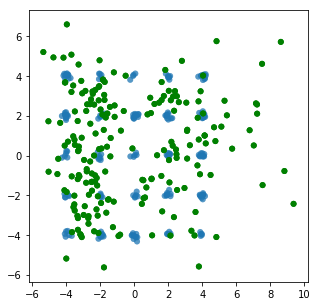

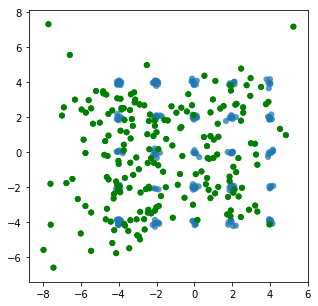

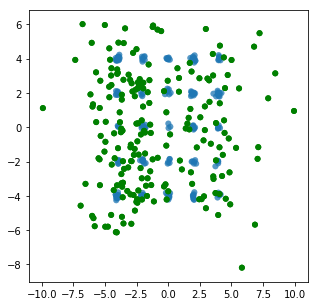

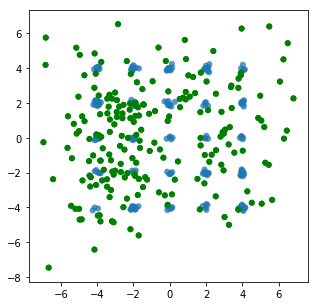

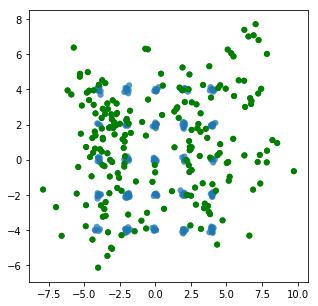

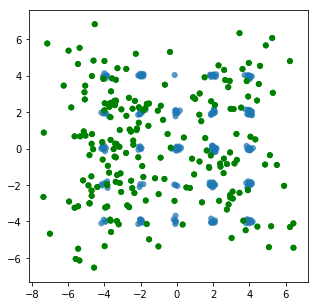

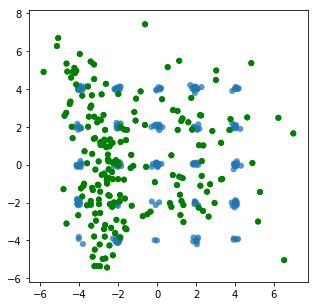

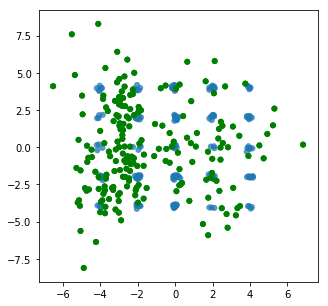

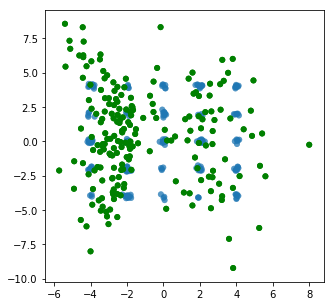

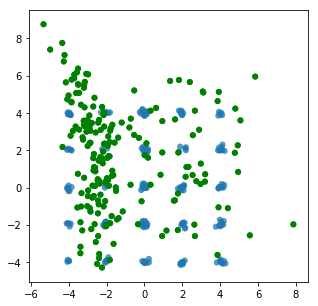

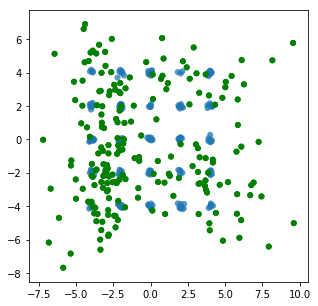

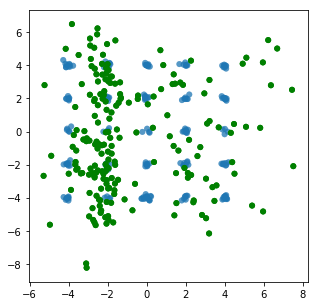

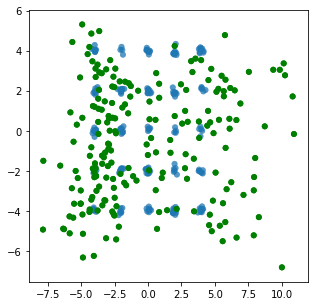

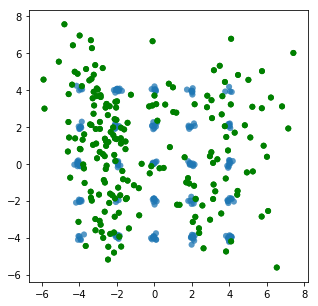

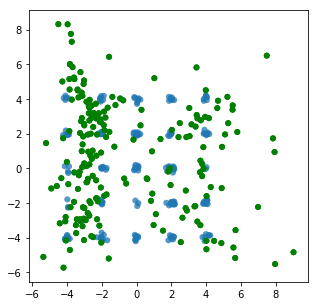

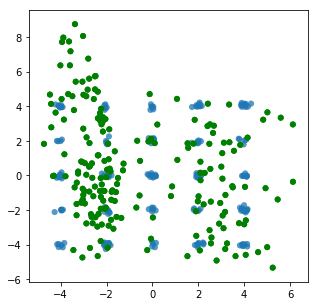

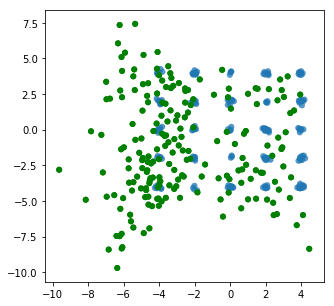

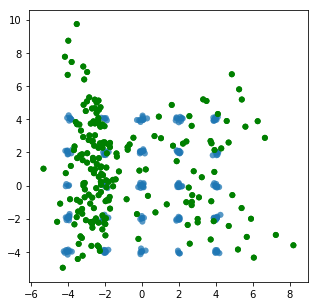

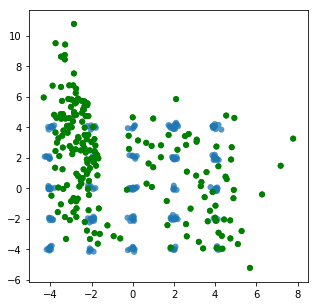

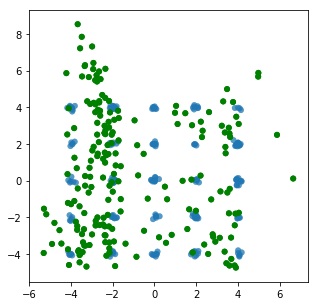

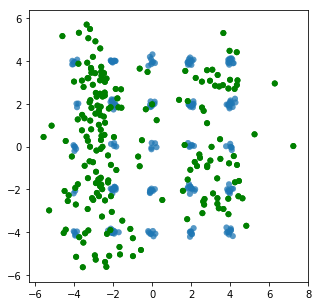

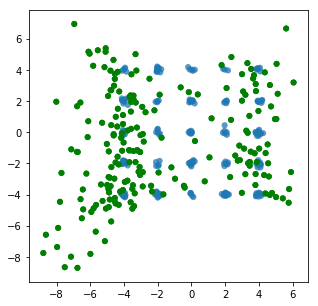

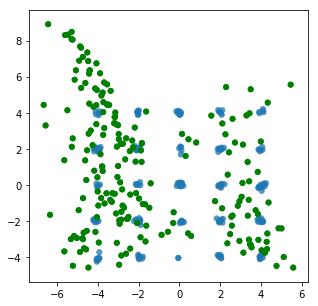

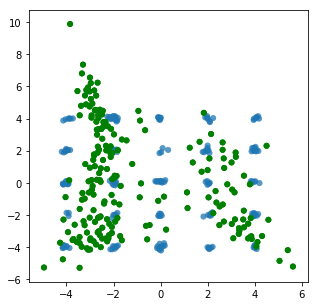

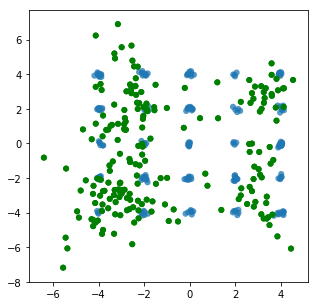

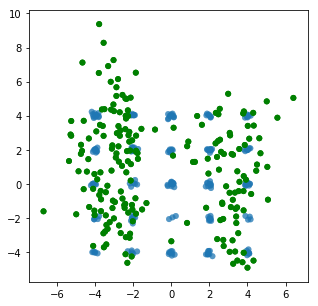

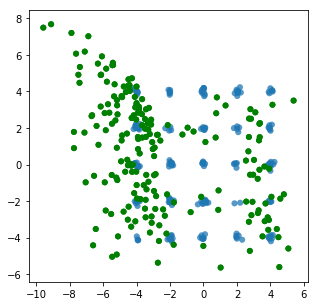

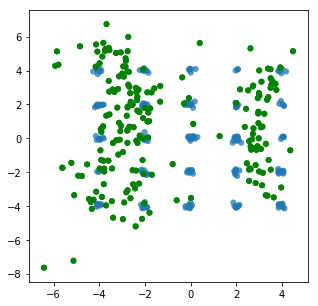

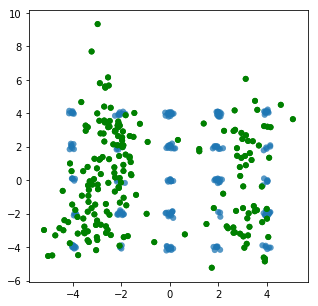

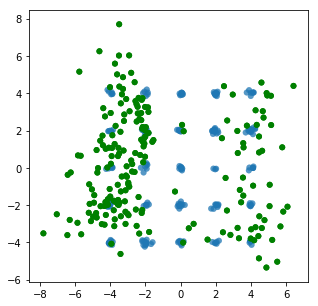

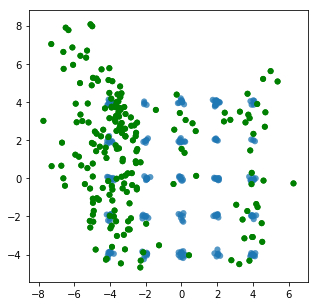

In [20]:
FOLDERNAME = ""
    #print(x)
if not os.path.exists(BASEDIR+FOLDERNAME):
    os.makedirs(BASEDIR+FOLDERNAME)

tf.reset_default_graph()
logfile = open(LOGFILE_NAME, "w")
data_generator = data_mixture([BATCH_SIZE, DATA_DIMS], name="data")
z, inputs, sampler, g_loss, d_loss, g_optim, d_optim = build_model()
counter =0
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    logfile.write(FOLDERNAME)
    for g_subiters in range(G_ITERS):
        # here at early stage of training, each update of G can be done after lots of updates 
        # of D to increase the performance
        # Update D network
        batch_data = sess.run(data_generator)
        batch_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)

        for j in range(D_ITERS):
            sess.run([d_optim], feed_dict={inputs: batch_data, z: batch_z })

            errD = d_loss.eval({z: batch_z, inputs: batch_data})
            logfile.write("g_iters: [%2d] discriminator training [%4d/%4d], d_loss: %.8f\n" %
                               (g_subiters, j+1, D_ITERS, errD))

            batch_data = sess.run(data_generator)
            batch_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)


        sess.run([g_optim], feed_dict={z: batch_z})


        batch_data = sess.run(data_generator)
        batch_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)

        errD = d_loss.eval({z: batch_z, inputs: batch_data})


        errG = g_loss.eval({z: batch_z})

        logfile.write("g_iters: [%2d], d_loss: %.8f, g_loss: %.8f\n" % (g_subiters, errD, errG))

        counter += 1

        batch_data = sess.run(data_generator)
        batch_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)


        sample_data = sess.run(data_generator)
        sample_z = np.random.normal(loc = 0.0, scale = 1, size = [BATCH_SIZE, Z_DIM]).astype(np.float32)


        samples, sample_d_loss, sample_g_loss = sess.run([sampler, d_loss, g_loss],feed_dict={z: sample_z, inputs: sample_data})


        #######plotting loss and distributions###########
        if np.mod(counter, 10) == 1:

            # here comes the visualization
            logfile.write("[Sample] d_loss: %.8f, g_loss: %.8f\n" % (sample_d_loss, sample_g_loss))

            xx = np.vstack([sample_data for _ in range(2)])
            yy= np.vstack([samples for _ in range(2)])
            fig_= plt.figure(figsize=(5,5), facecolor='w')
            plt.scatter(xx[:, 0], xx[:, 1],edgecolor='none', alpha=0.5)
            plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
            #plt.imshow(fig_)
            #fig_.suptitle('Fig %d/%d, %s, %s : ' % (G_ITERS,D_ITERS,DISTANCE,NORM))
            #savefig(BASEDIR+FOLDERNAME+'/%s %s %s %s ' % (counter, G_ITERS,NORM,DISTANCE))
logfile.close()